In [1]:
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from tqdm.notebook import tqdm
import torch.nn.functional as F
import GPUtil
import random

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

In [3]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=7)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [4]:
dataframe = pd.read_csv('../resource/emotion_classification.csv').dropna(axis=0)#.sample(frac=0.5)
#중립0 행복1 슬픔2 공포3 분노4 놀람5 혐오6 상처7
emodict = {'중립':0, '행복':1, '슬픔':2, '공포':3, '분노':4, '놀람':5, '혐오':6, '상처':7}
for k,v in emodict.items():
    dataframe = dataframe.replace(k, v)
#상처 감정 삭제
dataframe.drop(dataframe[dataframe['감정_대분류']==7].index, inplace=True)
dataframe[:10]

,사람문장1,감정_대분류
0,아내가 드디어 출산하게 되어서 정말 신이 나.,1
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,3
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,5
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,1
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,1
5,이제 곧 은퇴할 시기가 되었어. 내가 먼저 은퇴를 하고 육 개월 후에 남편도 은퇴를...,3
6,사십 대에 접어들면서 머리카락이 많이 빠져 고민이야.,2
7,이제 돈이라면 지긋지긋해.,4
8,친구들이 나를 괴롭혀. 부모님과 선생님께 얘기했는데도 믿어주지 않아.,4
9,친구 때문에 눈물 나.,2


In [5]:
dataframe['감정_대분류'].value_counts()

0    60577
2    28430
4    22794
5    19875
1    18148
3    16912
6    10026
Name: 감정_대분류, dtype: int64

<AxesSubplot:>

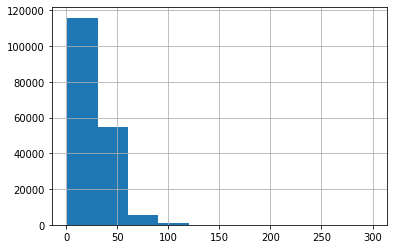

In [6]:
dataframe['사람문장1'].str.len().hist()

In [7]:
train_df, test_df = train_test_split(dataframe, test_size=0.2, random_state=42)

In [8]:
max_len = 128
batch_size = 64
learning_rate =  5e-5
epochs = 3
seed_val = 42

In [9]:
class MyDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx, 0]
        label = self.df.iloc[idx, 1]
        return text, label

In [10]:
train_dataset = MyDataset(train_df)
test_dataset = MyDataset(test_df)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [12]:
device = torch.device("cuda:0")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [13]:
optimizer = Adam(model.parameters(), lr=1e-5)
itr = 1
p_itr = 500
total_loss = 0
total_len = 0
total_correct = 0

In [14]:
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

for epoch in range(epochs):
    GPUtil.showUtilization()
    model.train()
    for batch_id, (text, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        model.zero_grad()
        encoded_list = [tokenizer.encode(t, add_special_tokens=True, max_length=max_len, pad_to_max_length=True) for t in text]
        sample = torch.tensor(encoded_list)
        labels = torch.tensor(label)
        sample, label = sample.to(device), label.to(device)
        labels = torch.tensor(label)
        outputs = model(sample, labels=labels)
        #loss, logits = outputs
        loss = outputs[0]
        logits = outputs[1]

        pred = torch.argmax(F.softmax(logits, dim=1), dim=1)
        correct = pred.eq(labels)
        total_correct += correct.sum().item()
        total_len += len(labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        if itr % p_itr == 0:
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, total_correct/total_len))
            total_loss = 0
            total_len = 0
            total_correct = 0
    #torch.save(model.state_dict(), './model.pt')
        itr+=1 
     
    model.eval()
    total_len = 0
    total_correct = 0
    for batch_id, (text, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        encoded_list = [tokenizer.encode(t, add_special_tokens=True, max_length=max_len, pad_to_max_length=True) for t in text]
        sample = torch.tensor(encoded_list)
        labels = torch.tensor(label)
        sample, label = sample.to(device), label.to(device)
        labels = torch.tensor(label)
        with torch.no_grad():    
            outputs = model(sample, labels=labels)
        
        logits = outputs[1]
        pred = torch.argmax(F.softmax(logits, dim=1), dim=1)
        correct = pred.eq(labels)
        total_correct += correct.sum().item()
        total_len += len(labels)
    print("epoch {} test acc {}".format(epoch+1, total_correct/total_len))
    total_len = 0
    total_correct = 0
    
        
        

| ID | GPU | MEM |
------------------
|  0 | 47% | 15% |


  0%|          | 0/2210 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\green\anaconda3\envs\cp\lib\site-packages\transformers\tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
C:\Users\green\AppData\Local\Temp\ipykernel_9604\4093315795.py:14: UserWarning: To copy 

[Epoch 1/3] Iteration 500 -> Train Loss: 1.6116, Accuracy: 0.405
[Epoch 1/3] Iteration 1000 -> Train Loss: 1.2730, Accuracy: 0.545
[Epoch 1/3] Iteration 1500 -> Train Loss: 1.1645, Accuracy: 0.586
[Epoch 1/3] Iteration 2000 -> Train Loss: 1.1218, Accuracy: 0.599


  0%|          | 0/553 [00:00<?, ?it/s]

C:\Users\green\AppData\Local\Temp\ipykernel_9604\4093315795.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)
C:\Users\green\AppData\Local\Temp\ipykernel_9604\4093315795.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)


epoch 1 test acc 0.6114049727038724
| ID | GPU | MEM |
------------------
|  0 | 58% | 96% |


  0%|          | 0/2210 [00:00<?, ?it/s]

[Epoch 2/3] Iteration 2500 -> Train Loss: 1.0631, Accuracy: 0.629
[Epoch 2/3] Iteration 3000 -> Train Loss: 1.0439, Accuracy: 0.628
[Epoch 2/3] Iteration 3500 -> Train Loss: 1.0303, Accuracy: 0.627
[Epoch 2/3] Iteration 4000 -> Train Loss: 1.0287, Accuracy: 0.632


  0%|          | 0/553 [00:00<?, ?it/s]

epoch 2 test acc 0.6431703108647073
| ID | GPU | MEM |
------------------
|  0 | 82% | 94% |


  0%|          | 0/2210 [00:00<?, ?it/s]

[Epoch 3/3] Iteration 4500 -> Train Loss: 1.0013, Accuracy: 0.666
[Epoch 3/3] Iteration 5000 -> Train Loss: 0.9579, Accuracy: 0.657
[Epoch 3/3] Iteration 5500 -> Train Loss: 0.9555, Accuracy: 0.658
[Epoch 3/3] Iteration 6000 -> Train Loss: 0.9612, Accuracy: 0.654
[Epoch 3/3] Iteration 6500 -> Train Loss: 0.9530, Accuracy: 0.658


  0%|          | 0/553 [00:00<?, ?it/s]

epoch 3 test acc 0.6409074194552089


##### 